In [3]:
import requests
import xml.etree.ElementTree as elemTree
import xmltodict

<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items/><numOfRows>10</numOfRows><pageNo>1</pageNo><totalCount>0</totalCount></body></response>


In [32]:
import json
base_url = "http://apis.data.go.kr/1741000/StanReginCd/getStanReginCdList"
params = {'pageNo':'1', 'numOfRows':'500', 'type':'json', 'locatadd_nm':'서울특별시', 'serviceKey':'jE27ZY2L6OW7dEan4q9+acDT4bs5QcyeBWR4e0ZO8B4bv36BiXdKKkr/ekQJNGV0LevLlo4NWm7Ka1OizI4EpQ=='}
res = requests.get(base_url,params=params) # 행정안전부 행정표준코드 법정동 코드
data = res.text
data = json.loads(data)
loc_res_list = []
for item in data['StanReginCd'][1]['row']:
    location_code = item['sido_cd'] + item['sgg_cd']
    loc_res_list.append(location_code)

loc_res_list = list(set(loc_res_list)) # 서울특별시에 해당하는 법정동 코드 유니크하게 추출
print(loc_res_list)

['11410', '11470', '11000', '11170', '11350', '11110', '11215', '11260', '11560', '11530', '11590', '11710', '11320', '11500', '11680', '11380', '11440', '11650', '11290', '11545', '11305', '11140', '11740', '11230', '11620', '11200']


In [ ]:
base_url = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade" # 국토부 아파트 매매 자료
params = {'serviceKey':'jE27ZY2L6OW7dEan4q9+acDT4bs5QcyeBWR4e0ZO8B4bv36BiXdKKkr/ekQJNGV0LevLlo4NWm7Ka1OizI4EpQ=='}

research_2021_date_list = ['202101','202102','202103','202104','202105','202106','202107','202108','202109','202110','202111','202112']
research_2022_date_list = ['202201','202202','202203','202204','202205','202206','202207','202208','202209','202210','202211','202212']
research_2023_date_list = ['202301','202302','202303','202304','202305','202306'] # 6월 까지만 있음
research_date_list = research_2021_date_list + research_2022_date_list + research_2023_date_list

trade_data_list = []

for loc in loc_res_list:
    for date in research_date_list:
        try:
            params['LAWD_CD'] = loc
            params['DEAL_YMD'] = date
            res = requests.get(base_url,params=params)
            res_data = json.dumps(xmltodict.parse(res.text))
            trade_data = json.loads(res_data)
            for item in trade_data['response']['body']['items']['item']:
                trade_price = item['거래금액']
                build_year = item['건축년도']
                apt_name = item['아파트']
                apt_floor = item['층']
                apt_size = item['전용면적']
                trade_date = item['년'] + item['월'] + item['일']
                trade_data_list.append([loc,date,trade_price,build_year,apt_name,apt_floor,apt_size,trade_date])
        except:
            continue

trade_data_list


In [92]:
len(trade_data_list)

69323

In [87]:
# 서울시 아파트 정보 데이터 전처리 - 시공사 순위
import pandas as pd
data_set = pd.read_csv("seoul_apt_info.csv", sep=",", encoding='cp949')
builder_set = pd.read_csv("builder_preprocessing.csv", sep=",",encoding='UTF8')

# 상호 변경된 건설사도 존재하기 때문에 '건설'과 '(주)' 텍스트 제거
data_set.replace({'k-건설사(시공사)':{'건설': '', '\(주\)':'', '주식회사':'', 'sk':'에스케이','SK':'에스케이','HDC':''}}, regex=True, inplace=True)
data_set['k-건설사(시공사)'].fillna('-', inplace=True)

for builder_idx in range(0, len(builder_set)):
    builder_name = builder_set.loc[builder_idx, '상호']
    builder_rank = builder_set.loc[builder_idx, '순위']
    for data_idx in range(0, len(data_set)):
        if (data_set.loc[data_idx, 'k-건설사(시공사)'] in builder_name):
            # print(builder_name, data_set.loc[data_idx, 'k-건설사(시공사)'])
            data_set.loc[data_idx, 'k-건설사(시공사) 순위'] = builder_rank
data_set

,번호,k-아파트명,"k-단지분류(아파트,주상복합등등)",kapt도로명주소,k-복도유형,k-전체동수,k-전체세대수,k-건설사(시공사),건축면적,주차대수,좌표X,좌표Y,k-건설사(시공사) 순위
0,1,우리유앤미,아파트,서울특별시 동작구 서달로 83,혼합식,2.0,206,우리,1773.56,223.0,126.959639,37.500668,2789.0
1,2,송파파인타운13단지,아파트,서울특별시 송파구 송파대로8길 10,계단식,4.0,197,양우,0.00,225.0,127.129179,37.476897,2880.0
2,3,오금현대백조(임대),아파트,서울특별시 송파구 양재대로72길 20,복도식,1.0,153,현대,6892.79,60.0,127.128775,37.508906,2430.0
3,4,개봉건영,아파트,서울특별시 구로구 고척로21나길 85-6,계단식,2.0,209,건영종합,0.00,0.0,126.840675,37.501162,2434.0
4,6,월계동원베네스트,아파트,서울특별시 노원구 월계로53길 21,계단식,5.0,205,동원,0.00,206.0,127.058220,37.631732,2911.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,40323,개포자이프레지던스,NaN,서울특별시 강남구 삼성로 14,혼합식,35.0,3375,GS,NaN,NaN,NaN,NaN,NaN
2746,40324,자양하늘채베르,아파트,서울특별시 광진구 자양로 55,계단식,2.0,165,코오롱,1689.88,169.0,127.084626,37.532832,16.0
2747,40326,삼전솔하임3차,도시형 생활주택(아파트),서울특별시 성북구 동소문로46길 18,복도식,1.0,190,삼전,NaN,NaN,NaN,NaN,1044.0
2748,40340,현대썬앤빌601,도시형 생활주택(주상복합),서울특별시 동대문구 장한로 91,복도식,1.0,193,현대BS&C,NaN,NaN,NaN,NaN,NaN


In [88]:
# data_set.to_csv("seoul_apt_info_preprocessing.csv", mode='w', encoding='cp949', index=False)
# 서울시 버스 정류장 거리 데이터 전처리
from haversine import haversine

bus_data_set = pd.read_csv("seoul_bus_info.csv", sep=",",encoding='cp949')
#nan data 제거
data_set.dropna(axis=0)

for data_idx in range(0, len(data_set)):
    apt_lati = data_set.loc[data_idx, '좌표Y']
    apt_long = data_set.loc[data_idx, '좌표X']
    bus_dis_list = []
    for bus_idx in range(0, len(bus_data_set)):
        bus_lati = bus_data_set.loc[bus_idx, '경도']
        bus_long = bus_data_set.loc[bus_idx, '위도']
        bus_dis = haversine([float(bus_lati),float(bus_long)],[float(apt_lati),float(apt_long)])
        bus_dis_list.append(bus_dis)
    data_set.loc[data_idx, '버스정류장최소거리'] = min(bus_dis_list)

data_set.to_csv("seoul_apt_info_bus_preprocessing.csv")


In [91]:
# 서울시 지하철(1-8호선)역 거리 데이터 전처리
subway_data_set = pd.read_csv("seoul_subway_info.csv", sep=",",encoding='cp949')
#우선 좌표 정보 없는 건 0.0으로 채워넣기
data_set['좌표Y'].fillna(0.0, inplace=True)
data_set['좌표X'].fillna(0.0, inplace=True)

for data_idx in range(0, len(data_set)):
    apt_lati = data_set.loc[data_idx, '좌표Y']
    apt_long = data_set.loc[data_idx, '좌표X']
    subway_dis_list = []
    for subway_idx in range(0, len(subway_data_set)):
        subway_lati = subway_data_set.loc[subway_idx, '경도']
        subway_long = subway_data_set.loc[subway_idx, '위도']
        subway_dis = haversine([subway_lati,subway_long],[apt_lati,apt_long])
        subway_dis_list.append(subway_dis)
    data_set.loc[data_idx, '지하철역최소거리'] = min(subway_dis_list)

data_set.to_csv("seoul_apt_info_subway_preprocessing.csv")

In [111]:
# 최종 실거래가 데이터 전처리
final_df = pd.DataFrame(columns=["floor", "houseCnt", "builderRank", "parkinglot", "bus", "subway", "size","buildYear","price"])

for trade_idx in range(0, len(trade_data_list)):
    for data_idx in range(0, len(data_set)):
        if (trade_data_list[trade_idx][4] in data_set.loc[data_idx, 'k-아파트명']):
            df2 = pd.DataFrame({'floor' : [trade_data_list[trade_idx][5]], 'houseCnt' : [data_set.loc[data_idx, 'k-전체세대수']], 'builderRank' : [data_set.loc[data_idx, 'k-건설사(시공사) 순위']], 'parkinglot' : [data_set.loc[data_idx, '주차대수']], 'bus' : [data_set.loc[data_idx, '버스정류장최소거리']], 'subway' : [data_set.loc[data_idx, '지하철역최소거리']], 'size' : [trade_data_list[trade_idx][6]], 'buildYear' : [trade_data_list[trade_idx][3]], 'price' :[float(trade_data_list[trade_idx][2].replace(',',''))]})
            final_df = final_df.append(df2, ignore_index=True)
            break
            
final_df.to_csv("seoul_apt_trade_preprocessing.csv", mode='w', encoding='cp949', index=False)

In [112]:
# K-Fold 교차검증 데이터 셋 분리
final_df = final_df.dropna(axis=0)

final_df.head()

,floor,houseCnt,builderRank,parkinglot,bus,subway,size,buildYear,price
0,10,258,2562.0,253.0,0.110316,6791.664869,45.89,2004,54800.0
1,20,258,2562.0,253.0,0.110316,6791.664869,44.88,2004,54500.0
3,11,561,2887.0,683.0,0.214917,6791.418756,84.99,2011,133000.0
4,6,561,2887.0,683.0,0.214917,6791.418756,84.99,2011,127500.0
5,8,561,2887.0,683.0,0.214917,6791.418756,114.98,2011,149000.0


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     2487.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        21:04:56   Log-Likelihood:            -2.2980e+05
No. Observations:               18813   AIC:                         4.596e+05
Df Residuals:                   18804   BIC:                         4.597e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.366e+05   3.33e+05      0.711      

c:\Users\User\anaconda3\envs\house_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44144 (\N{HANGUL SYLLABLE GEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


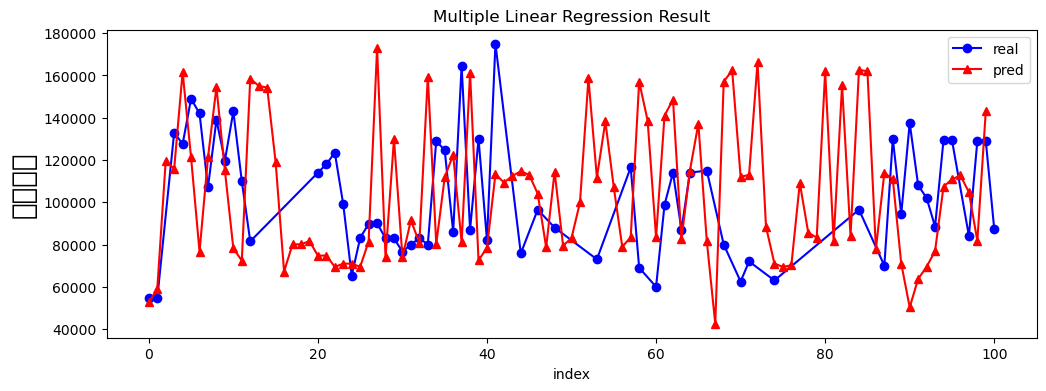

In [1]:
# 다변수 선형 회귀 모델
import pandas as pd 
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
#데이터 나누기
final_df = pd.read_csv("./seoul_apt_trade_preprocessing.csv")
final_df = final_df.dropna(axis=0)
X_data = final_df[['floor','houseCnt','builderRank','parkinglot','bus','subway','size','buildYear']]
# X_data = final_df[['floor','houseCnt','builderRank','parkinglot','bus','size']]
Y_data = final_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True, random_state=34)
# 연료 변수가 object이므로 더미화 진행 (type : 3개)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

import statsmodels.api as sm
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
# 모델 학습
model = linear_model.LinearRegression()
model.fit(X_data, Y_data)
model_pred = model.predict(X_data)
print(model.score(X_data, Y_data))
# 시각화
fig = plt.figure(figsize=(12,4))
graph = fig.add_subplot(1,1,1)
graph.plot(Y_data[:64],marker='o', label='real', color='blue')
graph.plot(model_pred[:100],marker='^', label='pred', color='red')
graph.set_title('Multiple Linear Regression Result')
plt.xlabel('index')
plt.ylabel('실거래가',size=20)
plt.legend(loc= 'best')
plt.show()

c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


시험용 데이터로 측정한 정확도 = 0.00


c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d ar

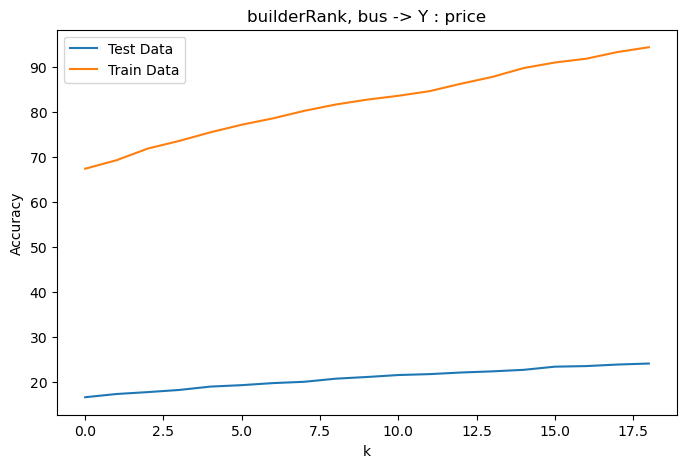

In [42]:
# KNN 모델
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

from sklearn.neighbors import KNeighborsClassifier
 
# 결과 군집화 (10000 이상, 50000 이상, 100000 이상)
knn_df = final_df.copy()
# # 실거래 값이 10000 이상 이라면 price 는 'A'
knn_df.loc[knn_df['price'] >= 10000, 'level'] = 'A'

# # 실거래 값이 50000 이상 이라면 price 는 'B'
knn_df.loc[knn_df['price'] >= 50000, 'level'] = 'B'

# # 실거래 값이 100000 이상 이라면 price 는 'C'
knn_df.loc[knn_df['price'] >= 100000, 'level'] = 'C'

# price 값이 'A' 와 'B', 'C' 가 아니라면 price 는 'F'
knn_df.loc[(knn_df['price'] != 10000) & (knn_df['price'] != 50000) & (knn_df['price'] != 100000), 'level'] = 'F' # 10000원 이하
# X_data = knn_df[['houseCnt']].to_numpy()
X_data = knn_df[['floor','houseCnt','builderRank','parkinglot','bus','subway','size','buildYear']].to_numpy()
# X_data = knn_df[['builderRank','bus']].to_numpy()
Y_data = knn_df[['price']].to_numpy()
trainX, testX, trainY, testY = train_test_split(X_data, Y_data, test_size= 0.2)
knn= KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
# k개수 5, 2의 power를 가진 minkowski거리 사용
knn.fit(trainX, trainY)
predY= knn.predict(trainX)
accuracy= (testY == predY).mean()
print("시험용 데이터로 측정한 정확도 = %.2f" % accuracy)

testAcc = []
trainAcc = []
for k in range(1,20): # k가 1부터 49까지
    # KNN 으로 Train 데이터 세트를 학습한다.
    knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='minkowski')
    knn.fit(trainX, trainY)
    
    # Test 세트의 Feature에 대한 정확도
    predY = knn.predict(testX)
    testAcc.append((testY == predY).sum() / len(predY))
    
    # Train 세트의 Feature에 대한 정확도
    predY = knn.predict(trainX)
    trainAcc.append((trainY == predY).sum() / len(predY))

plt.figure(figsize=(8, 5))
plt.plot(testAcc, label="Test Data")
plt.plot(trainAcc, label="Train Data")
plt.title('builderRank, bus -> Y : price')
plt.legend()
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

Epoch 1/100


c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\anaconda3\envs\house_env\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1317/1317 [==============================] - 1s 885us/step - loss: 17.4864 - accuracy: 0.9623 - val_loss: 0.4319 - val_accuracy: 0.9948
Epoch 2/100
1317/1317 [==============================] - 1s 830us/step - loss: 0.2944 - accuracy: 0.9942 - val_loss: 0.3099 - val_accuracy: 0.9948
Epoch 3/100
1317/1317 [==============================] - 1s 820us/step - loss: 0.2553 - accuracy: 0.9941 - val_loss: 0.2045 - val_accuracy: 0.9742
Epoch 4/100
1317/1317 [==============================] - 1s 780us/step - loss: 0.2348 - accuracy: 0.9940 - val_loss: 0.2278 - val_accuracy: 0.9951
Epoch 5/100
1317/1317 [==============================] - 1s 802us/step - loss: 0.1889 - accuracy: 0.9943 - val_loss: 0.1521 - val_accuracy: 0.9526
Epoch 6/100
1317/1317 [==============================] - 1s 821us/step - loss: 0.1649 - accuracy: 0.9940 - val_loss: 0.3312 - val_accuracy: 0.9951
Epoch 7/100
1317/1317 [==============================] - 1s 799us/step - loss: 0.1841 - accuracy: 0.9944 - val_loss: 0.1567 - val

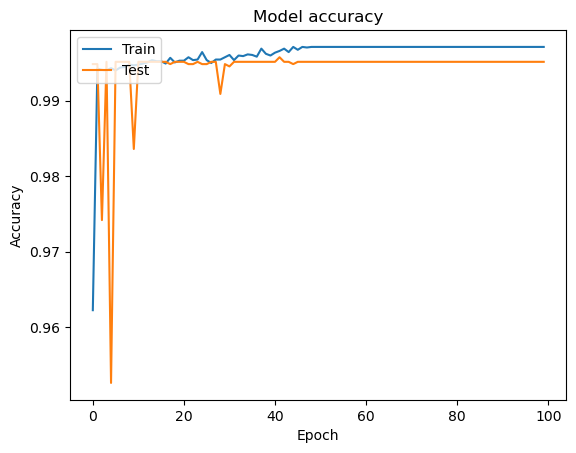

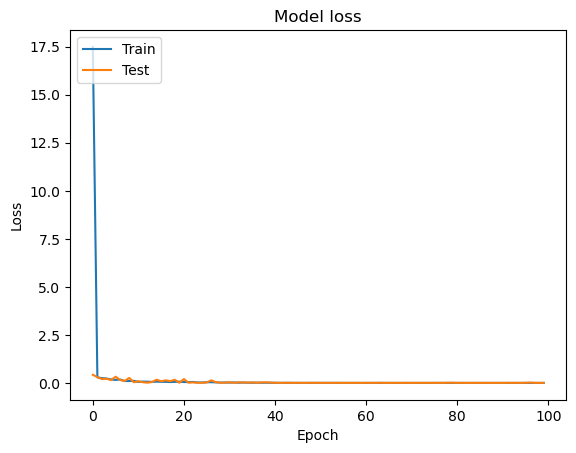

In [38]:
# 인공신경망 모델
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 결과 군집화 (10000 이상, 50000 이상, 100000 이상)
ann_df = final_df.copy()
# # 실거래 값이 10000 이상 이라면 price 는 'A'
ann_df.loc[ann_df['price'] >= 10000, 'price'] = 10000

# # 실거래 값이 50000 이상 이라면 price 는 'B'
ann_df.loc[ann_df['price'] >= 50000, 'price'] = 50000

# # 실거래 값이 100000 이상 이라면 price 는 'C'
ann_df.loc[ann_df['price'] >= 100000, 'price'] = 100000

# price 값이 'A' 와 'B', 'C' 가 아니라면 price 는 'F'
ann_df.loc[(ann_df['price'] != 10000) & (ann_df['price'] != 50000) & (ann_df['price'] != 100000), 'price'] = 5000 # 10000원 이하
# X_data = knn_df[['houseCnt']].to_numpy()
X_data = ann_df[['floor','houseCnt','builderRank','parkinglot','bus','subway','size','buildYear']].to_numpy()
# X_data = knn_df[['builderRank','bus']].to_numpy()
Y_data = ann_df[['price']].to_numpy()
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

x_data = X_data
y_data = Y_data
e = LabelEncoder()
e.fit(Y_data)
Y = e.transform(Y_data)
Y_encoded = tf.keras.utils.to_categorical(Y)
# 학습셋과 테스트셋의 구분
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_encoded, test_size=0.3, random_state=seed)
# 학습을 수행합니다.
model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, validation_split=0.2,epochs=100, batch_size=10)
score = model.evaluate(X_train, Y_train)
# 학습된 모델을 저장합니다.
# model.save('trade_house.h5')
print(model.summary())
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='under right')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='under right')
plt.show()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 8)                 72        
                                                                 
 dense_72 (Dense)            (None, 4)                 36        
                                                                 
 dense_73 (Dense)            (None, 2)                 10        
                                                                 
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________
None
221/221 [==============================] - 0s 777us/step - loss: 0.0097 - accuracy: 0.9969

 Accuracy: 0.9969


ValueError: 'under right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

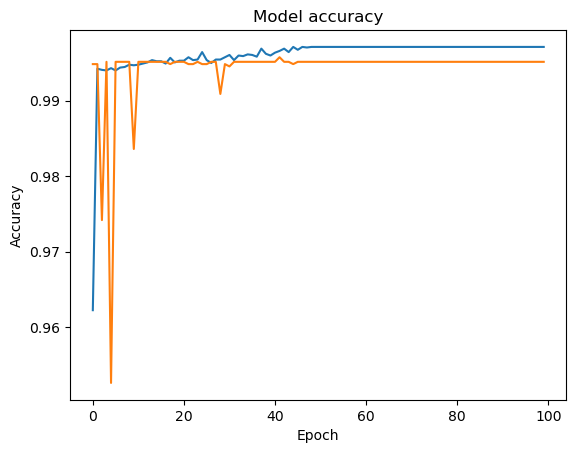

In [39]:
print(model.summary())
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='under right')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='under right')
plt.show()

In [28]:
# 실거래값 예측
import tensorflow as tf
import numpy as np

# 플레이스 홀더를 설정합니다.
X = tf.placeholder(tf.float32, shape=[None, 4])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W = tf.Variable(tf.random_normal([4, 1]), name="weight")
b = tf.Variable(tf.random_normal([1]), name="bias")

# 가설을 설정합니다.
hypothesis = tf.matmul(X, W) + b
# 저장된 모델을 불러오는 객체를 선언합니다.
saver = tf.train.Saver()
model = tf.global_variables_initializer()

# 4가지 변수를 입력 받습니다.
avg_temp = float(input('평균 온도: '))
min_temp = float(input('최저 온도: '))
max_temp = float(input('최고 온도: '))
rain_fall = float(input('강수량: '))

with tf.Session() as sess:
    sess.run(model)
    save_path = "./saved.cpkt"
    saver.restore(sess, save_path)

    data = ((avg_temp, min_temp, max_temp, rain_fall), (0, 0, 0, 0))
    arr = np.array(data, dtype=np.float32)

    x_data = arr[0:4]
    dict = sess.run(hypothesis, feed_dict={X: x_data})
    print(dict[0])

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
#시각화
# 시공사 순위에 따른 실거래가 추이



# 버스 정류장 거리에 따른 실거래가 추이


# 지하철역 거리에 따른 실거래가 추이